# Peak-Based Segmentation Demo


This notebook shows how to read the 20-squat recording in `data/raw/run.csv`, apply a simple low-pass filter, detect repetition valleys with `scipy.signal.find_peaks`, and visualize the resulting segments.

* Sampling rate: 100 Hz wrist IMU data.
* Filter: first-order low-pass for accel/gyro channels.
* Segmentation: detect minima on `accel_z_ms2`, then keep a 1.0 s pre-window and 1.2 s post-window per repetition.


In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.signal import find_peaks

plt.style.use('seaborn-v0_8')


In [2]:
DATA_PATH = Path('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/processed/filtered.csv')
FS = 100.0  # Hz

df = pd.read_csv(DATA_PATH)
df['time_s'] = df['loop'] / FS
df.head()


,loop,trig_cnt,accel_x_ms2,accel_y_ms2,accel_z_ms2,gyro_x_dps,gyro_y_dps,gyro_z_dps,time_s
0,0,0,0.122370,-0.099320,-9.793930,10.071630,-14.521840,-0.884510,0.00
1,1,0,0.122731,-0.093614,-9.787542,10.358396,-13.759907,-0.156734,0.01
2,2,0,0.128277,-0.084089,-9.747901,9.781284,-13.214470,-0.132882,0.02
3,3,0,0.131500,-0.069844,-9.722320,10.719324,-12.973694,0.634980,0.03
4,4,0,0.132437,-0.053147,-9.677877,11.172291,-12.897960,1.284969,0.04


In [3]:
accel_z = df['accel_z_ms2'].to_numpy()
inverse_signal = -accel_z  # convert valleys to peaks for detection
min_distance = int(FS * 2.0)  # squats last ~3s; 2s spacing avoids duplicates
peaks, properties = find_peaks(inverse_signal, prominence=0.3, distance=min_distance)

pre_window_s = 1.0
post_window_s = 1.2
pre_window = int(pre_window_s * FS)
post_window = int(post_window_s * FS)

segments = []
for seg_id, center in enumerate(peaks):
    start = max(0, center - pre_window)
    end = min(len(df), center + post_window)
    segment_df = df.iloc[start:end].reset_index(drop=True)
    segments.append({
        'segment_id': seg_id,
        'center_index': int(center),
        'start_index': int(start),
        'end_index': int(end),
        'start_time_s': float(df.loc[start, 'time_s']),
        'end_time_s': float(df.loc[end - 1, 'time_s']),
        'data': segment_df,
    })

segments_df = pd.DataFrame([
    {k: v for k, v in segment.items() if k != 'data'}
    for segment in segments
])
segments_df.head()


,segment_id,center_index,start_index,end_index,start_time_s,end_time_s
0,0,245,145,365,1.45,3.64
1,1,540,440,660,4.40,6.59
2,2,846,746,966,7.46,9.65
3,3,1147,1047,1267,10.47,12.66
4,4,1442,1342,1562,13.42,15.61


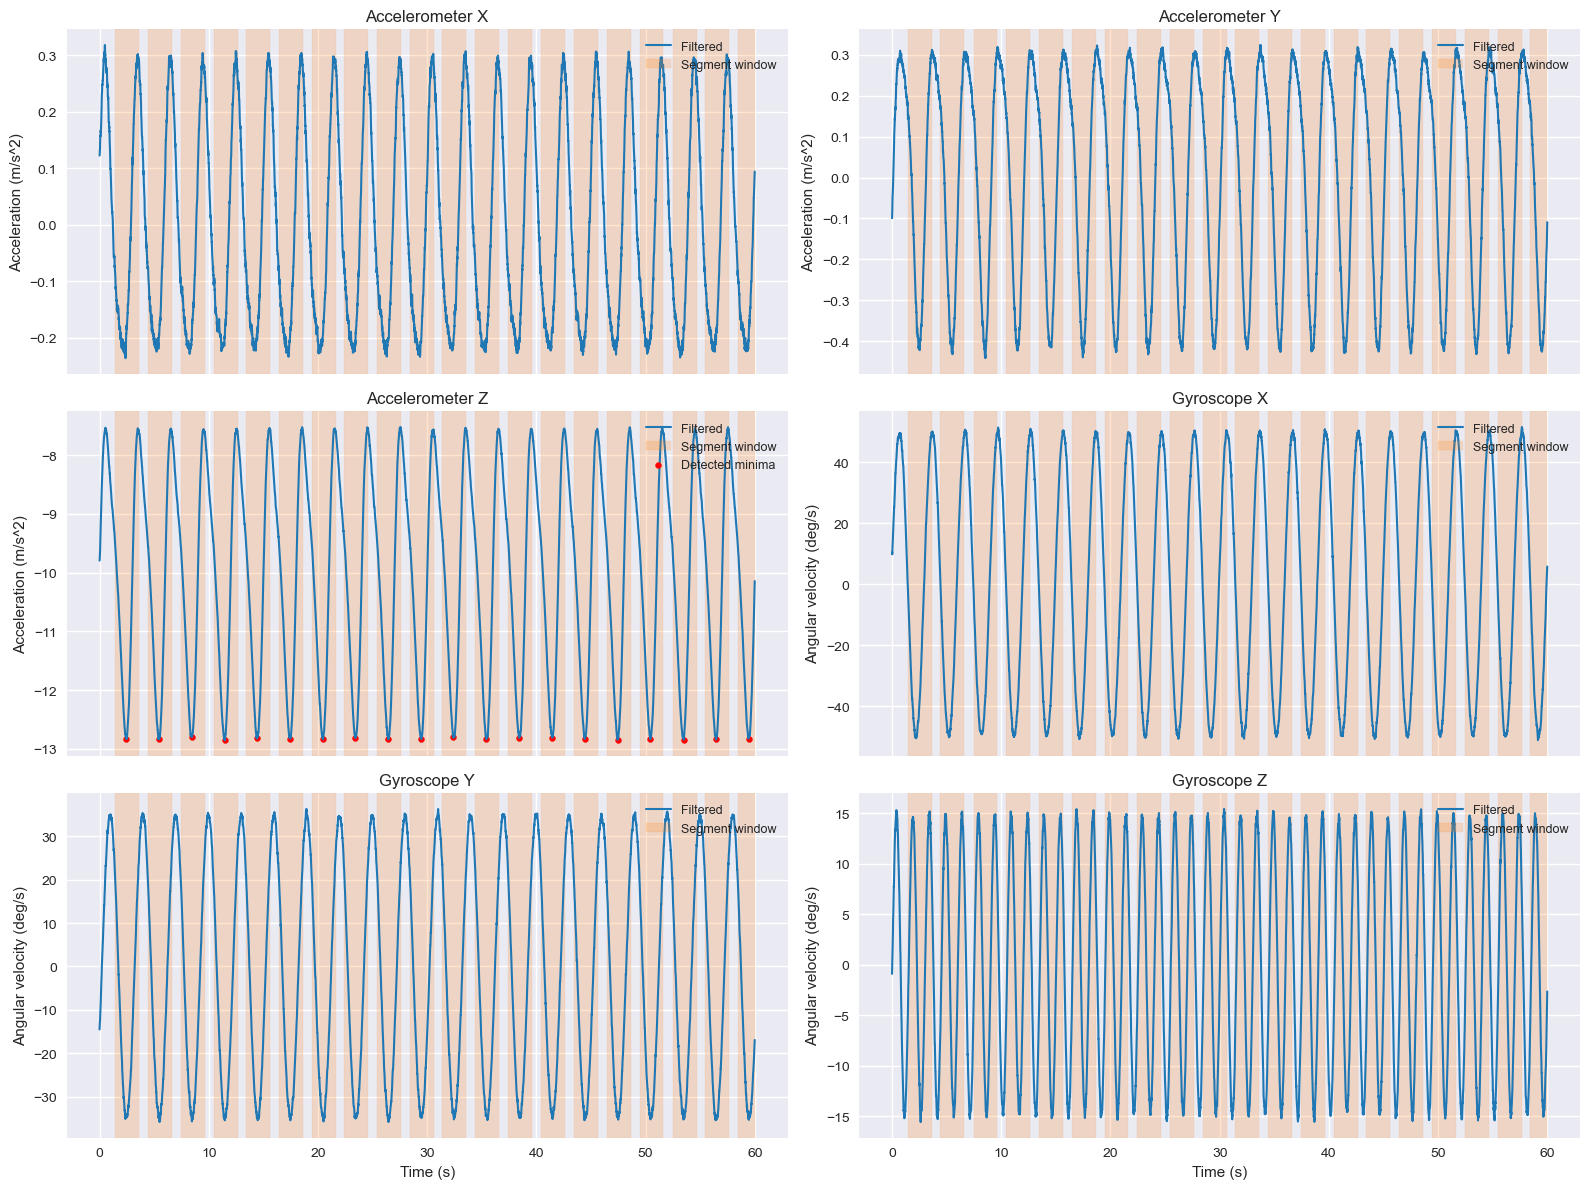

In [4]:
time_s = df['time_s'].to_numpy()
axis_configs = [
    ('accel_x_ms2', 'Accelerometer X', 'Acceleration (m/s^2)'),
    ('accel_y_ms2', 'Accelerometer Y', 'Acceleration (m/s^2)'),
    ('accel_z_ms2', 'Accelerometer Z', 'Acceleration (m/s^2)'),
    ('gyro_x_dps', 'Gyroscope X', 'Angular velocity (deg/s)'),
    ('gyro_y_dps', 'Gyroscope Y', 'Angular velocity (deg/s)'),
    ('gyro_z_dps', 'Gyroscope Z', 'Angular velocity (deg/s)'),
]

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()
window_patch = Patch(color='tab:orange', alpha=0.2, label='Segment window')

for ax, (column, title, ylabel) in zip(axes, axis_configs):
    line, = ax.plot(time_s, df[column], color='tab:blue', linewidth=1.5, label='Filtered')
    for segment in segments:
        ax.axvspan(segment['start_time_s'], segment['end_time_s'], color='tab:orange', alpha=0.2)
    handles = [line, window_patch]
    if column == 'accel_z_ms2' and len(peaks) > 0:
        scatter = ax.scatter(time_s[peaks], df[column].iloc[peaks], color='red', s=18, label='Detected minima')
        handles.append(scatter)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend(handles=handles, loc='upper right', fontsize=9)

for ax in axes[-2:]:
    ax.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()


In [5]:
print(f'Detected {len(segments)} segments.')
if segments:
    print('Preview of segment 0 (first five samples):')
    segments[0]['data'].head()
else:
    print('No segments found.')


Detected 20 segments.
Preview of segment 0 (first five samples):
